# GeoGuessr‑Style Country Classifier

## Project Overview
This project builds a machine learning classifier that predicts the country of a location based on visual and infrastructural clues, inspired by the game [<b>GeoGuessr</b>](https://www.geoguessr.com). The dataset was synthetically generated to simulate realistic Street View observations across seven countries.

---

## Dataset Overview
Because real Street View data is not used, a synthetic but realistic dataset was created to mimic the kinds of clues a human player would rely on:
- road markings
- driving side
- bollards
- utility poles
- signage
- guardrails
- landscape
- language visibility
- license plate rules
- Google car metadata

The goal is to explore how well a model can learn country‑level patterns from these features.
#### Countries Included:
- USA
- Canada
- United Kingdom
- France
- Brazil
- Japan
- Australia

Total Rows
200 (≈30 per country)

<b>Why these features and countries?</b>
They represent the most common Street‑View‑visible clues used by GeoGuessr players and are simple enough for a basic ML workflow.

---
## How the Dataset was Generated

Each row represents a **single Street‑View‑like location**, described using **medium‑simplicity categorical features** that capture realistic geographic and infrastructural clues.

The goal was to create a dataset that is:

- **Realistic**  
- **Varied**  
- **Ambiguous enough for ML**  
- **Consistent with real‑world geography**  
- **Beginner‑friendly**  
- **Free of coordinates**  (for now)


## Global Rules Applied Across All Countries

### Language & Script Visibility
To simulate real Street View:

- **Urban/suburban:** language usually visible  
- **Rural:** language often **none**  
- **Occasional n/a:** when the clue is irrelevant or not visible  

#### Rules:
- `language_hint ∈ {English, French, Portuguese, Japanese, none, n/a}`
- `script_type ∈ {Latin, Japanese, none, n/a}`
- If `language_hint = none`, then `script_type = none`

This introduces **realistic uncertainty**.


### License Plate Rules
To reflect real‑world variation:

- Some countries require front plates  
- Some allow optional  
- Some rows have **none** (no visible cars)

#### Rules:
- `license_plate ∈ {front_plate_required, front_plate_optional, none}`  
- Rural rows more likely to have `none`  
- Urban rows more likely to have `front_plate_required`  


### Feature Absence (Realistic Noise)
Not all locations have:

- bollards  
- guardrails  
- signs  
- poles  

So each of these can be:

- a realistic value  
- `none`  
- `n/a`  

This prevents the model from overfitting to “always present” clues.



### Landscape Categories
Landscapes were simplified into broad, ML‑friendly categories:

- urban  
- suburban  
- rural  
- forest  
- farmland  
- coastal  
- hilly  
- desert  
- outback (Australia only)



### Google Car Metadata
A simple binary-ish feature:

- `roof_rack`  
- `no_roof_rack`  

Used sparingly to avoid overfitting.


## Country‑Specific Rules

Each country follows its own **realistic infrastructure patterns**.

**Japan** → left driving, concrete/metal poles, white‑red bollards

**Brazil** → concrete poles, yellow center lines, roof‑rack car

**UK** → left driving, white‑black bollards, triangle warning signs

**USA** → yellow center lines, wooden poles, diamond warning signs

**France** → white‑red bollards, concrete poles, triangle signs

**Australia** → left driving, outback landscapes, white‑red bollards

**Canada** → English/French mix, wooden/metal poles, yellow center lines


## Randomization & Variation Logic

To avoid perfect patterns, each attribute has a probability distribution.

Rural rows have higher chance of:
- none language
- none signs
- none poles
- none guardrails
- none license plates

Urban rows have higher chance of:
- visible language
- required plates
- signs present
- poles present

This ensures the dataset is realistic and noisy, accurately reflecting the real-world.

---

# Now time for data cleaning:

In [1]:
# imports for data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# imports for ML
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

In [4]:
df = pd.read_csv("data/locations.csv")
df.head(204)

,country,language_hint,script_type,driving_side,road_lines,bollards,utility_poles,license_plate,sign_shapes,guardrails,landscape,google_car_meta
0,USA,English,Latin,right,yellow_center_white_edge,none,wooden_tall,front_plate_optional,diamond_warning,metal_w_beam,urban,no_roof_rack
1,USA,none,none,right,yellow_center_white_edge,none,none,none,none,none,rural,no_roof_rack
2,USA,English,Latin,right,white_center_white_edge,none,wooden_tall,front_plate_required,diamond_warning,none,urban,no_roof_rack
3,USA,English,Latin,right,yellow_center_white_edge,none,none,none,diamond_warning,none,forest,no_roof_rack
4,USA,English,Latin,right,yellow_center_white_edge,none,wooden_tall,front_plate_optional,none,none,suburban,no_roof_rack
...,...,...,...,...,...,...,...,...,...,...,...,...
199,Australia,none,none,left,white_center_white_edge,none,none,none,none,none,outback,no_roof_rack
200,Australia,English,Latin,left,white_center_white_edge,white_red,wooden_tall,front_plate_optional,diamond_warning,none,coastal,no_roof_rack
201,Australia,English,Latin,left,white_center_white_edge,none,metal_tall,none,none,none,suburban,no_roof_rack
202,Australia,English,Latin,left,white_center_white_edge,white_red,wooden_tall,front_plate_required,diamond_warning,metal_w_beam,hilly,no_roof_rack


In [5]:
df.shape # 204 rows, 12 columns

(204, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   country          204 non-null    object
 1   language_hint    204 non-null    object
 2   script_type      204 non-null    object
 3   driving_side     204 non-null    object
 4   road_lines       204 non-null    object
 5   bollards         204 non-null    object
 6   utility_poles    204 non-null    object
 7   license_plate    204 non-null    object
 8   sign_shapes      204 non-null    object
 9   guardrails       204 non-null    object
 10  landscape        204 non-null    object
 11  google_car_meta  204 non-null    object
dtypes: object(12)
memory usage: 19.3+ KB


In [7]:
df['country'].value_counts()

country
Australia    30
USA          29
Canada       29
UK           29
France       29
Brazil       29
Japan        29
Name: count, dtype: int64

# Plotting the number of countries in the data set:

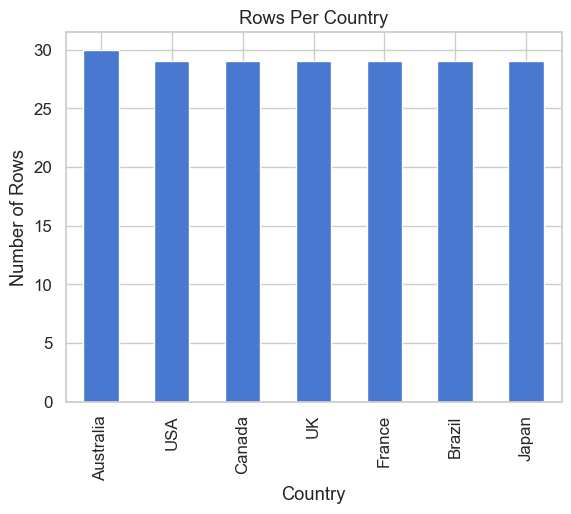

In [8]:
df['country'].value_counts().plot(kind='bar')
plt.title("Rows Per Country")
plt.ylabel("Number of Rows")
plt.xlabel("Country")
plt.show()

# Preparing the Data for ML

In [9]:
X = df.drop(columns=['country']) # all the clues
y = df['country'] # the answer

In [10]:
X_encoded = pd.get_dummies(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
) 

# test_size = 0.2 -> 20% of the data is used for testing
# stratify = y -> Makes sure each country appears in both sets
# random_state = 42 -> Makes the split reproducible

In [12]:
# Train the Model

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

In [13]:
# Make Predictions

y_pred = clf.predict(X_test)

# Check how good the model is

accuracy_score(y_test, y_pred) # 0.85 -> 85%, 1.0 -> 100%


0.8048780487804879

#### Based on the value above, this model has an **~80.49%** accuracy of guessing the country based on geolocation features.
---

# Creating a Confusion Matrix for better analysis:

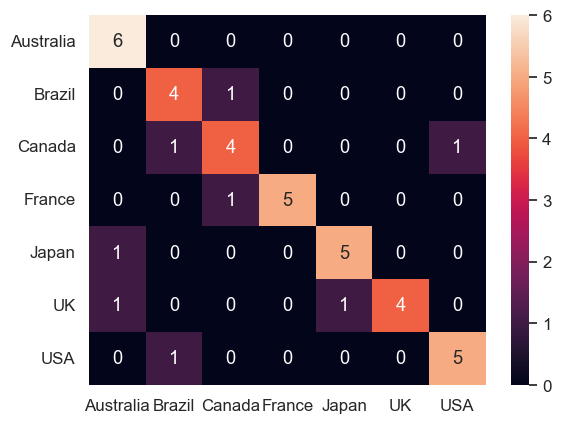

In [97]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=clf.classes_,
            yticklabels=clf.classes_)
plt.show()


## Interpretation of Confusion Matrix
- Strong diagonal values → the model correctly identifies many countries
- Some confusion exists (e.g., Japan → Australia), which is expected
- Rural rows with missing features increase ambiguity
- Overall, this model demonstrates meaningful learning and not random guessing
---

In [75]:
# SEE WHAT CLUES THE MODEL THINKS ARE IMPORTANT

importances = clf.feature_importances_
feature_names = X_encoded.columns

pd.Series(importances, index=feature_names).sort_values(ascending=False).head(15)


driving_side_right                     0.091833
language_hint_Portuguese               0.075079
driving_side_left                      0.074579
language_hint_English                  0.065892
language_hint_French                   0.053798
road_lines_yellow_center_white_edge    0.043476
language_hint_Japanese                 0.042543
road_lines_white_center_white_edge     0.040122
script_type_Japanese                   0.039307
sign_shapes_triangle_warning           0.035404
landscape_forest                       0.028765
sign_shapes_diamond_warning            0.028462
script_type_Latin                      0.026718
bollards_white_red                     0.025274
bollards_white_black                   0.024850
dtype: float64

## Analysis:
- Based on the data above, the model thinks properties like **driving direction** and **languages hints** are the most important pieces of information when making a guess.
- This aligns with what I think makes sense since driving direction and knowing the language are huge clues when playing **GeoGuessr**.
---

# Conclusion
This project has been especially meaningful to me because it connects directly to something I genuinely enjoy: the challenge and intuition of playing GeoGuessr. Re‑creating that experience through data instead of images turned out to be surprisingly fascinating. It pushed me to think about what actually makes a place feel like a place: the road markings, the poles, the signs, the landscapes, and all the subtle cues that I normally process instinctively while playing.

By turning those observations into structured features and training a model on them, I was able to achieve an accuracy of around 80%, which is exciting given that the dataset is entirely synthetic. The confusion matrix showed that the model learned many of the same distinctions I rely on as a GeoGuessr player: Japan’s poles, Australia’s left‑side driving, Brazil’s concrete infrastructure, and the familiar patterns of the US and Canada. At the same time, the model struggled in the same places I do, like distinguishing France from the UK or Canada from the US when the clues overlap or disappear.

The feature importance results were especially interesting because they confirmed that the model gravitates toward the same “anchor clues” that humans use. Seeing those patterns emerge from data I designed myself made the whole process feel both validating and surprisingly fun.

Overall, this project showed me that even without real images, it’s possible to capture the logic of geographic inference in a structured, interpretable way. It deepened my appreciation for the subtlety of GeoGuessr and gave me a new perspective on how machine learning can model human intuition. I’m excited to keep expanding this idea, whether by adding more countries, features, or eventually combining this structured approach with real image embeddings.